# Data Analysis:

### Required Libraries:

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

### Importing and pre-processing data:

In [2]:
df = pd.read_csv("PsyToolkitData_BRED_PROJECT_5_Nov/data.csv")
# print(df.columns)

def convert_group(a):
    if a == 1:
        return "walking"
    if a == 2:
        return "joystick"
    return "invalid"

def convert_gender(a):
    if a == 1:
        return "woman"
    if a == 2:
        return "man"
    return "other"

def preprocessing_data():
    df["condition"] = df["psy_group"].apply(convert_group)
    df["gender"] = df["d_gender_1"].apply(convert_gender)

### Function to get General Statistics:

In [3]:
def lists_stats(walking, joystick, thing):
    # Calculate statistics for walking
    mean1 = np.mean(walking)
    median1 = np.median(walking)
    mode1 = stats.mode(walking, keepdims=True)[0][0]
    std_dev1 = np.std(walking)

    # Calculate outliers for walking using IQR
    q1_1, q3_1 = np.percentile(walking, [25, 75])
    iqr1 = q3_1 - q1_1
    lower_bound1 = q1_1 - 1.5 * iqr1
    upper_bound1 = q3_1 + 1.5 * iqr1
    outliers1 = [v for v in walking if v < lower_bound1 or v > upper_bound1]

    # Calculate statistics for joystick
    mean2 = np.mean(joystick)
    median2 = np.median(joystick)
    mode2 = stats.mode(joystick, keepdims=True)[0][0]
    std_dev2 = np.std(joystick)

    # Calculate outliers for joystick using IQR
    q1_2, q3_2 = np.percentile(joystick, [25, 75])
    iqr2 = q3_2 - q1_2
    lower_bound2 = q1_2 - 1.5 * iqr2
    upper_bound2 = q3_2 + 1.5 * iqr2
    outliers2 = [v for v in joystick if v < lower_bound2 or v > upper_bound2]

    # Print the statistics and outliers
    print(f"Walking Statistics for {thing}:")
    print(f"Mean: {mean1:.3f}")
    print(f"Median: {median1}")
    print(f"Mode: {mode1}")
    print(f"Standard Deviation: {std_dev1:.3f}")
    print(f"Outliers: {outliers1}\n")

    print(f"Joystick Statistics for {thing}:")
    print(f"Mean: {mean2:.3f}")
    print(f"Median: {median2}")
    print(f"Mode: {mode2}")
    print(f"Standard Deviation: {std_dev2:.3f}")
    print(f"Outliers: {outliers2}\n")

### Functions to Plot Data:

In [4]:
def lists_boxplot(walking, joystick, labels):
    # Plot combined box plot
    plt.boxplot([walking, joystick], vert=True, labels=['Walking', 'Joystick'])
    plt.title(f"Box Plots of {labels[0]} for the two {labels[1]}s")
    plt.ylabel(labels[0])
    plt.xlabel(labels[1])
    plt.show()

def lists_histogram(walking, joystick, bins):

    plt.figure(figsize=(10, 6))
    plt.hist(walking, bins=bins, color="blue", alpha=0.5, edgecolor="black", label="Walking", align='left')
    plt.hist(joystick, bins=bins, color="red", alpha=0.5, edgecolor="black", label="Joystick", align='left')

    # Labels and title
    plt.xlabel("Number of Correct Objects")
    plt.ylabel("Frequency")
    plt.title("Histogram of Objects Correctly Placed for Each Condition")
    plt.xticks(range(5))  # Set x-ticks to be at each bin center for clarity
    plt.legend()
    plt.show()

### Functions for Analysis:

In [5]:
def demographic_analysis():
    print(f"Gender of Participants:\t"
          f"Women: {df['gender'].value_counts()['woman']},"
          f" Men: {df['gender'].value_counts()['man']}")
    print(f"Age of participants:"
          f"\tMean: {df['d_age_1'].mean():.3f}, SD: {df['d_age_1'].std():.3f}")
    print(f"Number of participants in each Condition:\n"
          f"Walking: {df['condition'].value_counts()['walking']}\n"
          f"Joystick: {df['condition'].value_counts()['joystick']}")
    print(f"Time Taken for Completion of Entire Experiment:"
          f"\n\tMean: {df['TIME_total'].mean():.3f}, SD: {df['TIME_total'].std():.3f}\n")

def ssq_analysis():
    nausea = [1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1]
    oculomotor = [1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0]
    disorientation = [0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 2, 1, 0, 0]

    v_question_columns = [col for col in df.columns if col.startswith('v_questions')]
    # Calculate the mean across 'v_questions' columns for each 'condition'
    grouped_means = df.groupby('condition')[v_question_columns].mean()
    # Convert each row of means to a list for each unique 'condition' value
    result = {group: row.tolist() for group, row in grouped_means.iterrows()}
    # print(result)

    # Final score multiplier
    final_multiplier = 3.74
    # Calculate the final scores for each 'condition'
    final_scores = {}
    for group, scores in result.items():
        # Calculate weighted sums for each category
        nausea_score = sum(s * w for s, w in zip(scores, nausea))
        oculomotor_score = sum(s * w for s, w in zip(scores, oculomotor))
        disorientation_score = sum(s * w for s, w in zip(scores, disorientation))
        # Sum of all categories and apply final multiplier
        total_score = (nausea_score + oculomotor_score + disorientation_score) * final_multiplier
        final_scores[group] = total_score

    print("SSQ scores (out of 300 approx.): ", final_scores)

def presence_analysis():
    joystick_scores = df["presence_overall_1"][df["condition"] == 'joystick'].tolist()
    walking_scores = df["presence_overall_1"][df["condition"] == 'walking'].tolist()
    lists_stats(walking_scores, joystick_scores, "Presence")
    lists_boxplot(walking_scores, joystick_scores,
                  ["Overall Presence", "Condition"])

def task_performance():
    joystick_times = df["joystick_time_1"][df["condition"] == 'joystick'].tolist()
    walking_times = df["walking_time_1"][df["condition"] == 'walking'].tolist()
    lists_stats(walking_times, joystick_times,
                "Time for Task Completion")
    lists_boxplot(walking_times, joystick_times,
                  ["Time Taken (in s)", "Condition"])

    joystick_scores = df["joystick_score_1"][df["condition"] == 'joystick'].tolist()
    walking_scores = df["walking_score_1"][df["condition"] == 'walking'].tolist()
    lists_stats(walking_scores, joystick_scores,
                "Objects Correctly Placed")
    lists_histogram(walking_scores, joystick_scores,
                    [0, 1, 2, 3, 4, 5])

## Analysis:

### 1) Demographic Analysis:

In [6]:
preprocessing_data()
demographic_analysis()

Gender of Participants:	Women: 5, Men: 27
Age of participants:	Mean: 19.531, SD: 0.803
Number of participants in each Condition:
Walking: 19
Joystick: 13
Time Taken for Completion of Entire Experiment:
	Mean: 13.344, SD: 2.364



### 2) Simulator Sickness Analysis:

In [7]:
preprocessing_data()
ssq_analysis()

SSQ scores (out of 300 approx.):  {'joystick': 32.509230769230776, 'walking': 6.298947368421052}


### 3) Presence Analysis:

Walking Statistics for Presence:
Mean: 6.110
Median: 6.09
Mode: 5.91
Standard Deviation: 0.379
Outliers: [5.09]

Joystick Statistics for Presence:
Mean: 5.433
Median: 5.45
Mode: 3.09
Standard Deviation: 0.950
Outliers: [3.09]



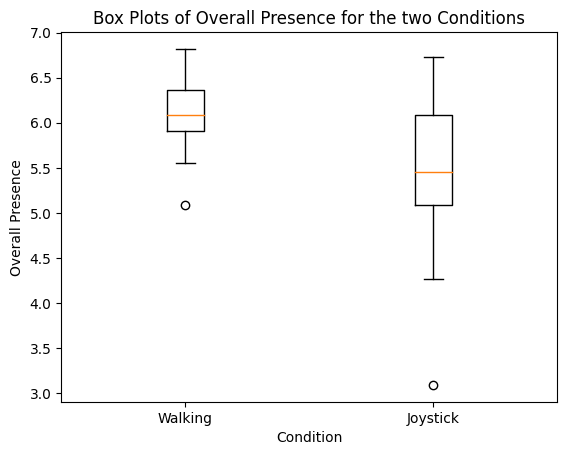

In [8]:
preprocessing_data()
presence_analysis()

### 4) Task Performance Analysis:

Walking Statistics for Time for Task Completion:
Mean: 44.536
Median: 44.73
Mode: 23.64
Standard Deviation: 11.717
Outliers: []

Joystick Statistics for Time for Task Completion:
Mean: 110.001
Median: 107.3
Mode: 48.77
Standard Deviation: 51.333
Outliers: [246.0]



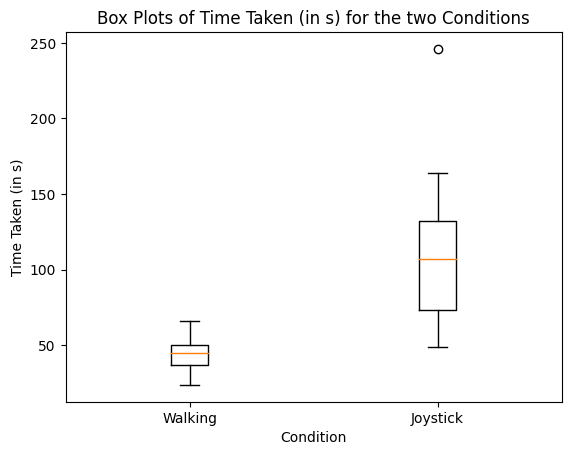

Walking Statistics for Objects Correctly Placed:
Mean: 3.895
Median: 4.0
Mode: 4.0
Standard Deviation: 0.447
Outliers: [2.0]

Joystick Statistics for Objects Correctly Placed:
Mean: 1.692
Median: 2.0
Mode: 2.0
Standard Deviation: 1.380
Outliers: []



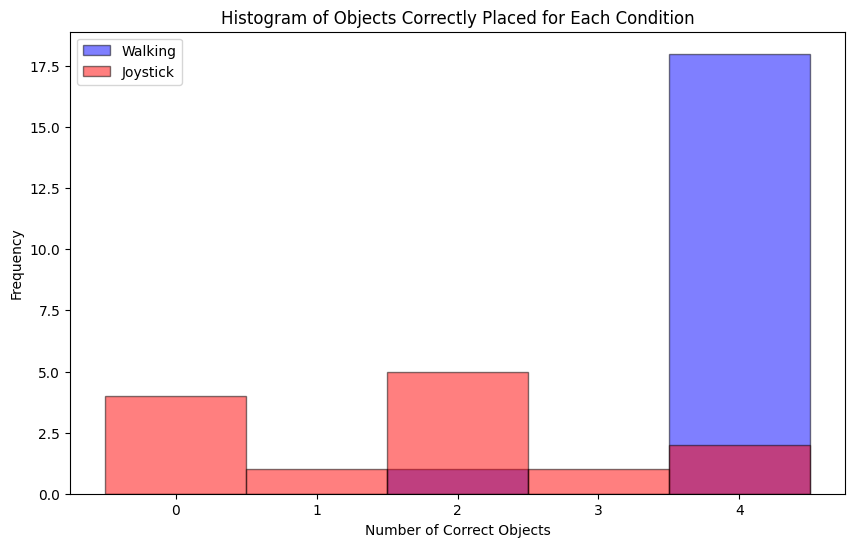

In [9]:
preprocessing_data()
task_performance()